# Build an RL-Guided Fuzz Testing Engine for BSTs

In this tutorial, we will show how Atlas enables us to turn a dumb fuzzer into an effective rl-guided one.

Full paper with more in-depth examples coming soon!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## A Binary Search Tree Class
Let's first define a binary search tree class. 

In [2]:
# A binary search tree class
class BinarySearchTree:

    def __init__(self, value):
        self.value = value
        self.left = None
        self.right = None

    # Insert to_add into the tree
    def insert(self, to_add):
        if self.value == to_add:
            return
        if self.value > to_add:
            if self.left:
                self.left.insert(to_add)
            else:
                self.left = BinarySearchTree(to_add)
        else:
            if self.right:
                self.right.insert(to_add)
            else:
                self.right = BinarySearchTree(to_add)
    
    # Find whether to_find
    def find(self, to_find):
        if self.value == to_find:
            return self
        elif self.value > to_find:
            if self.left:
                return self.left.find(to_find)
            else:
                return None
        else:
            if self.right:
                return self.right.find(to_find)
            else:
                return None
            
    # Check whether the tree satisfies the binary search tree invariant. 
    # I.e., left child is a BST, right child is a BST, and self's value
    # is greater than the left child's value and smaller than the right
    # child's value.
    def is_bst(self):
        left_ok = True
        if self.left:
            left_ok = self.left.all_values_less_than(self.value) and self.left.is_bst()
        right_ok = True
        if self.right:
            right_ok = self.right.all_values_greater_than(self.value) and self.right.is_bst()
        return right_ok and left_ok

    # Helper method that returns true if all values in `self` are less than `value`
    def all_values_less_than(self, value):
        if self.value >= value:
            return False
        left_less_than = True
        if self.left:
            left_less_than = self.left.all_values_less_than(value)

        right_less_than = True
        if self.right:
            right_less_than = self.right.all_values_less_than(value)
        return left_less_than and right_less_than
    
    # Helper method that returns true if all values in `self` are greater than `value`
    def all_values_greater_than(self, value):
        if self.value <= value:
            return False
        left_greater_than = True
        if self.left:
            left_greater_than = self.left.all_values_greater_than(value)

        right_greater_than = True
        if self.right:
            right_greater_than = self.right.all_values_greater_than(value)
        return left_greater_than and right_greater_than

    def __repr__(self, indent=0):
        left_repr = self.left.__repr__(indent + 1) if self.left else " None"
        right_repr = self.right.__repr__(indent + 1) if self.right else " None"
        return f"({self.value}\n{indent*'  '}L{left_repr}\n{indent*'  '}R{right_repr})"


Say we want to test our insert function. One way to do this is to fuzz test: we'll generate many random trees, and try to insert random numbers into them, and check that the tree is still a binary search tree after insertion.

Because we're lazy, let's just write a generator that generates any binary search tree:

In [3]:
from atlas import generator

MAX_DEPTH = 4

@generator(strategy='randomized')
def generate_tree(depth=0):
    value = Select(range(0, 11))
    tree = BinarySearchTree(value) 
    if depth < MAX_DEPTH and Select([True, False]):
        tree.left = generate_tree(depth+1)
    if depth < MAX_DEPTH and Select([True, False]):
        tree.right = generate_tree(depth+1) 
    return tree 

Because we're lazy, this may not actually create trees that satisfy the binary search tree invariant. We can still use it for fuzzing if we call it enough times:

In [4]:
import random
TRIALS=10000

def test_insert(tree, to_add):
    if tree.is_bst():
        tree.insert(to_add)
        assert(tree.is_bst())
        return True
    else:
        return False

# Keep track of the valid BSTs we generate
def fuzz():
    n = 0
    num_bsts = 0
    unique_bsts = set()
    generator = generate_tree
    while n < TRIALS:
        tree = generator.call()
        tree_repr = tree.__repr__()
        to_add = random.choice(range(-10,20))
        is_bst = test_insert(tree, to_add)
        if is_bst:
            num_bsts += 1
            unique_bsts.add(tree_repr)
        n += 1
        print(f"{n} trials, {num_bsts} binary search trees, {len(unique_bsts)} unique BSTs", end='\r')
    return unique_bsts
        
    

How well do we do with this randomized generation strategy?

In [5]:
bsts = fuzz()

1467 trials, 472 binary search trees, 84 unique BSTs

2627 trials, 820 binary search trees, 114 unique BSTs

3466 trials, 1070 binary search trees, 133 unique BSTs

4731 trials, 1452 binary search trees, 164 unique BSTs

5842 trials, 1782 binary search trees, 187 unique BSTs

7032 trials, 2166 binary search trees, 203 unique BSTs

8464 trials, 2596 binary search trees, 216 unique BSTs

Looks like around 2% of the randomly-generated inputs where unique BSTs. But what kind of binary search trees? Let's look at the distribution of sizes. 

([<matplotlib.axis.XTick at 0x11a26dfd0>,
 <a list of 5 Text xticklabel objects>)

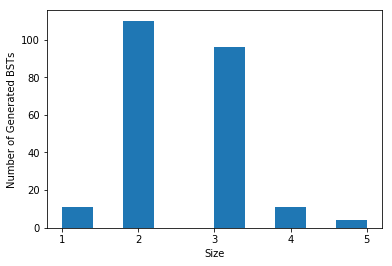

In [6]:
# Size is the number of nodes in the tree
sizes = [str_repr.count("(") for str_repr in bsts]
plt.hist(sizes)
plt.ylabel("Number of Generated BSTs")
plt.xlabel("Size")
plt.xticks(list(set(sizes)))

Hmm, looks like even though our naive random generator was able to generate some binary search trees, they weren't very complex. It had difficulty randomly creating valid binary search trees with more than 3 nodes, because it's randomly choosing which values to put in the tree with its Select operators.

What if we made those select operators smarter? In particular, what if we used reinforcement learning to decide what to do at each selection operator?

Let's start by defining a simple learner following a monte-carlo control policy. 

In [7]:
from numpy.random import binomial
from collections import defaultdict

class MCCLearner:

    def __init__(self,  epsilon=0.25, gamma=1.0, initial_val=0):
        self.epsilon = epsilon
        self.gamma = gamma
        self.episode = []
        self.initial_val = initial_val
        self.Q_table = defaultdict(dict)
        self.C_table = defaultdict(dict)

    # updates upon full episodes
    def reward(self, reward):
         # reward the last choice
         self.episode[-1][2] = reward
         T = len(self.episode)
         G = 0
         W = 1
         for i in range(T):
             s, a, r = self.episode[T - i - 1] # ranges from T-1, T-2, ... 0.
             G = self.gamma*G + r
             self.C_table[s][a] = self.C(s, a) + W
             self.Q_table[s][a] = self.Q(s, a) + (W/self.C(s, a)) * (G - self.Q(s, a))
         self.episode = []

    def Q(self, s: str, a: str):
        try:
            return self.Q_table[s][a]
        except KeyError:
            return self.initial_val

    def C(self, s: str, a: str):
        try:
            return self.C_table[s][a]
        except KeyError:
            return self.initial_val

    def policy(self, domain, state):
        domain = list(domain)
        # Epsilon-greedy strategy
        if binomial(1, self.epsilon):
            choice = random.choice(domain)
        else:
            self.action_values = np.array([self.Q(state, a) for a in domain])
            action_idx = random.choice(np.flatnonzero(self.action_values == self.action_values.max())) # break ties randomly
            choice = domain[action_idx]
        self.episode.append([state, choice, 0])
        return choice


We can now use these learners to back all our calls to Select. 

In [8]:
from typing import Callable, Optional, Collection

from atlas.operators import OpInfo
from atlas.strategies import Strategy, operator


class MCCStrategy(Strategy):
    
    def __init__(self):
        super().__init__()
        self.learners = {}
        
    def generic_call(self, domain=None, context=None, op_info: OpInfo = None, handler: Optional[Callable] = None,
                     **kwargs):
        return handler(domain=domain, context=context, op_info=op_info, **kwargs)

    def is_finished(self):
        return False
    
    def get_learner(self, sid):
        if sid not in self.learners:
            self.learners[sid] = MCCLearner()
        return self.learners[sid]
    
    def reward(self, r):
        for learner in self.learners.values():
            learner.reward(r)
        
    @operator
    def Select(self, domain, op_info=None, context=None, **kwargs):
        sid = op_info.sid
        learner = self.get_learner(sid)
        choice = learner.policy(domain, tuple(context))
        return choice


Now, we just need to modify our generator to add some minimal context for each call:

In [9]:
mcc_strategy = MCCStrategy()

WINDOW_SIZE = 4
def concat_tail(lst, val):
    return (lst + [val])[-WINDOW_SIZE:]

@generator(strategy=mcc_strategy)
def generate_tree(context, depth=0):
    value = Select(range(0, 11), context=context)
    # Add the last choice of value to the context
    context = concat_tail(context, value)
    tree = BinarySearchTree(value) 
    if depth < MAX_DEPTH and Select([True, False], context=context):
        # We're generating the left child now
        tree.left = generate_tree(concat_tail(context, "LEFT"), depth+1)
    if depth < MAX_DEPTH and Select([True, False], context=context):
        # We're generating the right child now
        tree.right = generate_tree(concat_tail(context, "RIGHT"), depth+1) 
    return tree 

Let's try fuzzing again, this time rewarding the strategy if it generates a new binary search tree:

In [10]:
# Keep track of the valid BSTs we generate
def fuzz():
    n = 0
    num_bsts = 0
    unique_bsts = set()
    generator = generate_tree
    while n < TRIALS:
        tree = generate_tree.call([])
        tree_repr = tree.__repr__()
        to_add = random.choice(range(-10,20))
        is_bst = test_insert(tree, to_add)
        if is_bst:
            num_bsts += 1
            if tree_repr not in unique_bsts:
                unique_bsts.add(tree_repr)
                mcc_strategy.reward(20)
            else:
                mcc_strategy.reward(0)
        else:
            mcc_strategy.reward(-1)
        n += 1
        print(f"{n} trials, {num_bsts} binary search trees, {len(unique_bsts)} unique BSTs", end='\r')
    return unique_bsts
        

In [11]:
trees = fuzz()

523 trials, 369 binary search trees, 29 unique BSTs

900 trials, 584 binary search trees, 63 unique BSTs

1246 trials, 768 binary search trees, 88 unique BSTs

1592 trials, 936 binary search trees, 121 unique BSTs

2248 trials, 1246 binary search trees, 166 unique BSTs

2565 trials, 1394 binary search trees, 195 unique BSTs

2880 trials, 1533 binary search trees, 218 unique BSTs

3167 trials, 1657 binary search trees, 241 unique BSTs

3485 trials, 1804 binary search trees, 257 unique BSTs

3785 trials, 1942 binary search trees, 283 unique BSTs

4335 trials, 2219 binary search trees, 327 unique BSTs

4571 trials, 2328 binary search trees, 358 unique BSTs

4867 trials, 2470 binary search trees, 390 unique BSTs

5204 trials, 2636 binary search trees, 429 unique BSTs

5494 trials, 2767 binary search trees, 459 unique BSTs

6509 trials, 3239 binary search trees, 571 unique BSTs

6846 trials, 3397 binary search trees, 602 unique BSTs

7157 trials, 3538 binary search trees, 639 unique BSTs

7472 trials, 3701 binary search trees, 665 unique BSTs

7794 trials, 3834 binary search trees, 698 unique BSTs

8063 trials, 3945 binary search trees, 731 unique BSTs

8381 trials, 4076 binary search trees, 774 unique BSTs

8693 trials, 4230 binary search trees, 808 unique BSTs

8989 trials, 4385 binary search trees, 856 unique BSTs

9341 trials, 4561 binary search trees, 896 unique BSTs

9624 trials, 4684 binary search trees, 920 unique BSTs

9923 trials, 4815 binary search trees, 943 unique BSTs

Cool! We generated over 4x more binary search treest than the random strategy. Are they of more diverse sizes as well?

([<matplotlib.axis.XTick at 0x11a711080>,
 <a list of 9 Text xticklabel objects>)

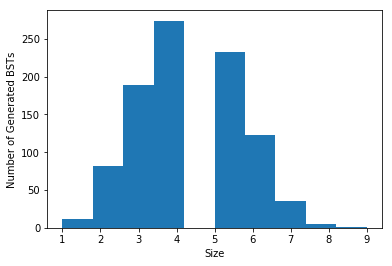

In [12]:
# Size is the number of nodes in the tree
sizes = [str_repr.count("(") for str_repr in trees]
plt.hist(sizes)
plt.ylabel("Number of Generated BSTs")
plt.xlabel("Size")
plt.xticks(list(set(sizes)))

Looks like it. We see tons of trees of sizes 4 and 5, and even some of sizes 6 and 7!